In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np


In [2]:
with open('hin.txt','r') as f:
  data = f.read()

In [3]:
uncleaned_data_list = data.split('\n')
len(uncleaned_data_list)
uncleaned_data_list = uncleaned_data_list[:38695]
len(uncleaned_data_list)

2980

In [4]:
english_word = []
hindi_word = []

for word in uncleaned_data_list:
    parts = word.split('\t')
    if len(parts) >= 2:  # Check if there are at least two parts after splitting
        english_word.append(parts[0])
        hindi_word.append(parts[1])
    else:
        print(f"Skipping invalid entry: {word}")

language_data = pd.DataFrame(columns=['English', 'Hindi'])
language_data['English'] = english_word
language_data['Hindi'] = hindi_word

language_data.to_csv('language_data.csv', index=False)

Skipping invalid entry: 


In [5]:
english_text = language_data['English'].values
hindi_text = language_data['Hindi'].values
len(english_text), len(hindi_text)

(2979, 2979)

In [6]:
english_text

array(['Wow!', 'Duck!', 'Duck!', ...,
       'Democracy is the worst form of government, except all the others that have been tried.',
       'If my boy had not been killed in the traffic accident, he would be a college student now.',
       "When I was a kid, touching bugs didn't bother me a bit. Now I can hardly stand looking at pictures of them."],
      dtype=object)

In [7]:
hindi_text

array(['वाह!', 'झुको!', 'बतख़!', ...,
       'लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी सारी तरह की सरकारों को अंदेखा किया जाए तो।',
       'अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया होता, तो वह अभी कॉलेज जा रहा होता।',
       'जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई परेशानी नहीं होती थी, पर अब मैं उनकी तस्वीरें देखना भी बर्दाश्त नहीं कर सकता।'],
      dtype=object)

In [8]:
type(english_text[0])

str

In [9]:
#to lower case
english_text_ = [x.lower() for x in english_text]
hindi_text_ = [x.lower() for x in hindi_text]
#removing inverted commas
english_text_ = [re.sub("'",'',x) for x in english_text_]
hindi_text_ = [re.sub("'",'',x) for x in hindi_text_]
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
hindi_text_ = remove_punc(hindi_text_)
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text
# removing the digits from the Hindi sentances
hindi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in hindi_text_]
hindi_text_ = [re.sub("[\u200d]","",x) for x in hindi_text_]
# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
hindi_text_ = [x.strip() for x in hindi_text_]


In [10]:
# Putting the start and end words in the Hindi sentances
hindi_text_ = ["start " + x + " end" for x in hindi_text_]
# manipulated_Hindi_text_
hindi_text_[100], english_text_[100]


('start मैं आऊंगा। end', 'ill attend')

In [11]:
X = english_text_
Y = hindi_text_
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.1)

In [12]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_
#Training data
max_length_english = Max_length(X_train)
max_length_hindi = Max_length(y_train)
#Test data
max_length_english_test = Max_length(X_test)
max_length_hindi_test = Max_length(y_test)
max_length_hindi, max_length_english

(27, 22)

In [13]:
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1
X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')
X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')
hindiTokenizer = Tokenizer()
hindiTokenizer.fit_on_texts(y_train)
Hword2index = hindiTokenizer.word_index
vocab_size_target = len(Hword2index) + 1
y_train = hindiTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_hindi, padding='post')
y_test = hindiTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_hindi, padding='post')
vocab_size_source, vocab_size_target


(2281, 2896)

In [14]:
X_train[0], y_train[0]

(array([1213,    6,    1,  859, 1214,    8,  520,  651,   43,    1,  328,
          16,   14,   70,  290,    0,    0,    0,    0,    0,    0,    0],
       dtype=int32),
 array([   1, 1368,  581,   18,  178, 1369,  477,   11,  165,  945,  211,
         157,   14, 1370,   13, 1371,  109,  722,  946,    2,    0,    0,
           0,    0,    0,    0,    0], dtype=int32))

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

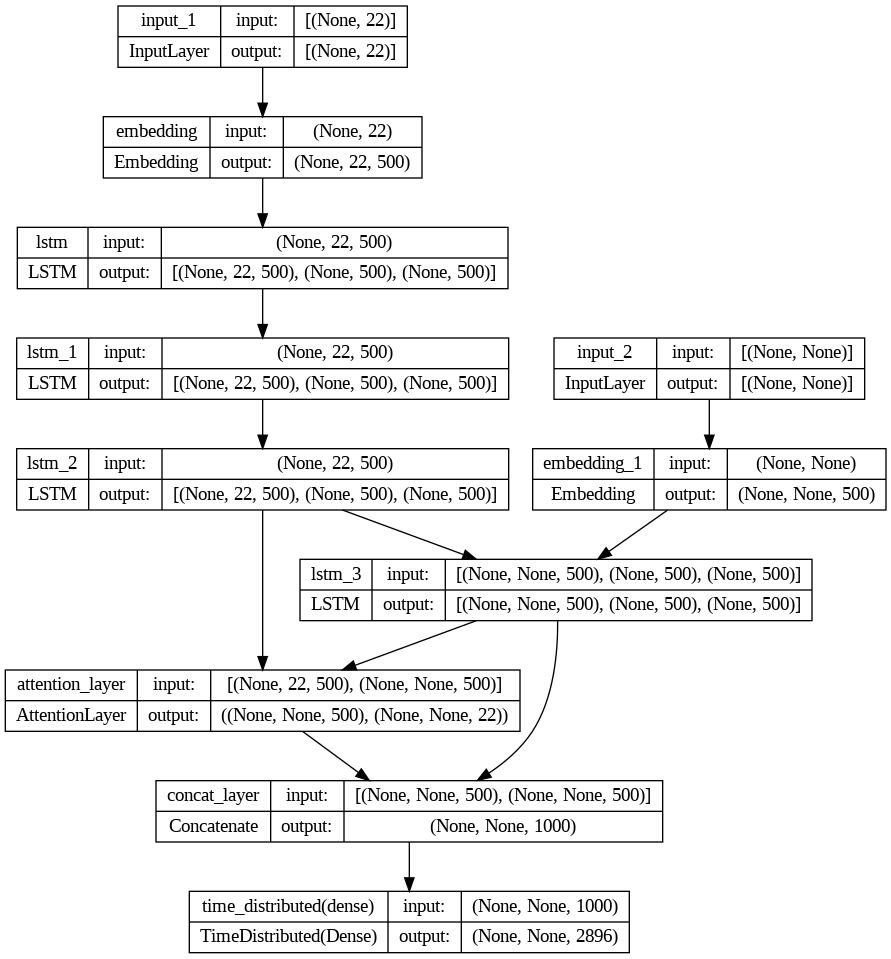

In [16]:
from transformer import AttentionLayer
from keras import backend as K
K.clear_session()
latent_dim = 500
# Encoder
encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)
#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
#Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, to_file='train_model.png', show_shapes=True)


In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [18]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=50,
                    batch_size=512,
                    validation_data = ([X_test, y_test[:,:-1]],           y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))


Epoch 1/50
6/6 [==============================] - 23s 853ms/step - loss: 6.0312 - accuracy: 0.5639 - val_loss: 2.0878 - val_accuracy: 0.7282
Epoch 2/50
6/6 [==============================] - 3s 476ms/step - loss: 2.2147 - accuracy: 0.6989 - val_loss: 1.8146 - val_accuracy: 0.7317
Epoch 3/50
6/6 [==============================] - 3s 482ms/step - loss: 2.0098 - accuracy: 0.7030 - val_loss: 1.8442 - val_accuracy: 0.7296
Epoch 4/50
6/6 [==============================] - 4s 607ms/step - loss: 2.0322 - accuracy: 0.7018 - val_loss: 1.7528 - val_accuracy: 0.7303
Epoch 5/50
6/6 [==============================] - 3s 487ms/step - loss: 1.9678 - accuracy: 0.7020 - val_loss: 1.7565 - val_accuracy: 0.7303
Epoch 6/50
6/6 [==============================] - 3s 471ms/step - loss: 1.9615 - accuracy: 0.7018 - val_loss: 1.7210 - val_accuracy: 0.7305
Epoch 7/50
6/6 [==============================] - 3s 461ms/step - loss: 1.9380 - accuracy: 0.7020 - val_loss: 1.7149 - val_accuracy: 0.7305
Epoch 8/50
6/6 [===

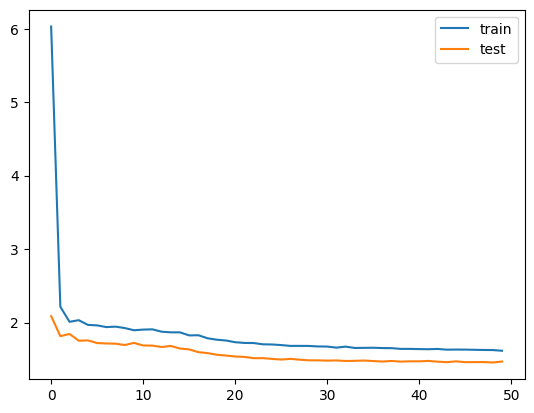

In [20]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [21]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")


Saved model to disk


In [22]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")


In [23]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs
#print(encoder_outputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(32,latent_dim))
# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


In [24]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Choose the 'start' word as the first word of the target sequence.
    target_seq[0, 0] = Hword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token.
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            break
        else:
            sampled_token = Hindex2word[sampled_token_index]
            if sampled_token != 'end':
                decoded_sentence += ' ' + sampled_token
            # Exit condition: either hit max length or find stop word.
            if sampled_token == 'end' or len(decoded_sentence.split()) >= (26 - 1):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states.
        e_h, e_c = h, c

    return decoded_sentence


In [25]:
Eindex2word = englishTokenizer.index_word
Hindex2word = hindiTokenizer.index_word


In [26]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Hword2index['start']) and i!=Hword2index['end']):
        newString=newString+Hindex2word[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString


In [27]:
decode_sequence(X_test[10].reshape(1,32))

ValueError: ignored

In [ ]:
type(X_test[10])

In [ ]:
for i in range(10):
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,32)))
  print("\n")
